In [75]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster       import KMeans

import math

import votinglib_funcs as vf
# self-defined library

from importlib import reload

# define threshold of popular support for major parties:
MAJ_PARTY_THRESH=0.05
WORKDIR = os.getcwd()
Vote_data_path = "./source_data/DL_BE_AB2016_V2_formatted.txt"

In [85]:
reload(vf)

<module 'votinglib_funcs' from '/Users/lana/Documents/projects/voting_patterns/calculations/votinglib_funcs.py'>

In [3]:
Data_RAW = pd.read_csv( Vote_data_path, sep="\t", header=0 )
n_ridings     = Data_RAW.shape[0]
n_parties_all = Data_RAW.shape[1]-17

#Data_RAW.head
print( Data_RAW.shape )
print( n_ridings )
print( n_parties_all )

(2432, 43)
2432
26


In [4]:
# cross-check that the sum of all party votes adds up to the "valid" column
assert max(abs([sum( Data_RAW.values[n,17:]) for n in range(n_ridings) ] -  Data_RAW.values[:,16])) == 0
# first index corresponding to a party's vote tally is 17, continues in decreasing order of total votes.
party_names_all = Data_RAW.columns[17:]

print(party_names_all)

Index(['SPD', 'CDU', 'GRÜNE', 'LINKE', 'PIRATEN', 'NPD', 'FDP',
       'Tierschutzpartei', 'pro.Deutschland', 'DiePARTEI', 'BIG', 'DKP', 'ödp',
       'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz', 'AfD',
       'DIE.EINHEIT', 'DIE.VIOLETTEN', 'Graue.Panther', 'MENSCHLICHE.WELT',
       'MIETERPARTEI', 'Gesundheits.forschung'],
      dtype='object')


In [5]:
# separate ridings into "Urnen" (ballot box) Bezirks, and "Brief" (mail-in ballot) bezirks
Data_Urn   = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Urnenwahlbezirk" ]
Data_Brief = Data_RAW.loc[ Data_RAW["Wahlbezirksart"] == "Briefwahlbezirk" ]
# Old way of doing it: Data_Urn   = Data_RAW.set_index("Wahlbezirksart").loc["Urnenwahlbezirk"]

n_ridings_urn = Data_Urn.shape[0]
print( n_ridings_urn )

# ====== we will work primarily with the "Urn" data (since there are many more of them)
# we'll come back to the Brief data later to check for robustness.

1779


In [6]:
major_parties, minor_parties = vf.get_major_minor_parties( Data_RAW.iloc[:,17:], MAJ_PARTY_THRESH )

n_parties_major = len(major_parties)

print( "Major parties : "); print( major_parties )
print( "Minor parties : "); print( minor_parties )

Major parties : 
['SPD', 'CDU', 'GRÜNE', 'LINKE', 'FDP', 'AfD']
Minor parties : 
['ALFA', 'B', 'BIG', 'BüSo', 'DIE.EINHEIT', 'DIE.VIOLETTEN', 'DKP', 'DL', 'DiePARTEI', 'Gesundheits.forschung', 'Graue.Panther', 'MENSCHLICHE.WELT', 'MIETERPARTEI', 'NPD', 'PIRATEN', 'PSG', 'Tierschutzallianz', 'Tierschutzpartei', 'pro.Deutschland', 'ödp']


In [36]:
# create a normalized table of normalized Vote shares amongst major parties: 
VS_urn      = vf.get_normal_maj_VS( Data_Urn, major_parties, minor_parties, add_other = False )
VS_urn_full = vf.get_normal_maj_VS( Data_Urn, major_parties, minor_parties, add_other = True )

# create numpy-array versions:
VS_urn_np      = VS_urn.values.copy()
VS_urn_full_np = VS_urn_full.values.copy()

# The latter has a column for all "others" (i.e. minor parties + invalid)

In [29]:
# Data_nc = "normed and centered"; work with this from here on out.
VS_urn_nc = VS_urn - np.mean( VS_urn, axis=0)


In [30]:
# isolate an O-W list for the classifier:
OW_urn = Data_Urn["OstWest"].values

# Get the mean positions of each of the groups
meanpoint_Ost  = np.mean( VS_urn.loc[ OW_urn =="O"  ] )
meanpoint_West = np.mean( VS_urn.loc[ OW_urn =="W"  ] )

# And define a vector pointint in the direction from one to the other.
OW_vec = (meanpoint_Ost - meanpoint_West)/np.linalg.norm( meanpoint_Ost - meanpoint_West ) 

print (np.linalg.norm( OW_vec ))

1.0


In [31]:
 # ==========================================================================================================

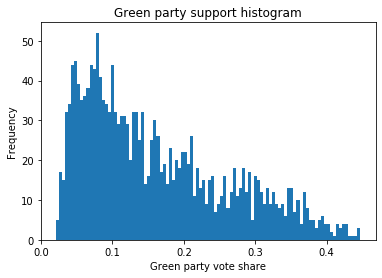

In [32]:
dummy = plt.hist( VS_urn ["GRÜNE"], 
                  bins = 100)
dummy = plt.xlabel("Green party vote share")
dummy = plt.ylabel("Frequency")
dummy = plt.title("Green party support histogram")

In [37]:
pca  = PCA()
VS_urn_np_PC = pca.fit_transform( VS_urn_np )
# confirm that absdiffs are unchanged
print( normdiff( VS_urn_np ,    52 , 21) )
print( normdiff( VS_urn_np_PC , 52 , 21) )

0.157870489037546
0.1578704890375459


In [44]:
# VS_urn

In [41]:
# define color-codes for plotting the bezirks, starting with a list of integers for who won the region.
Winner_list = [ np.argmax( VS_urn.iloc[n].values) for n in  range(n_ridings_urn) ]
len(Winner_list)

# followed by the Ost/West boundary
OW_ccode       = [ "blue"  if x=="W" else "red"   for x in Data_Urn["OstWest"].values ]
Go20pc_ccode   = [ "green" if x>0.2  else "black" for x in VS_urn["GRÜNE"]   ]
Gwinner_ccode  = [ "green" if x==2   else "black" for x in Winner_list ]

Gwinner_OW_ccode  = [ "green" if Winner_list[x]==2 
                       else "blue" if OW_urn[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

Go20pc_OW_ccode  = [ "green" if VS_urn["GRÜNE"][x] >0.2 
                       else "blue" if OW_urn[x]=="W" 
                       else "red" 
                       for x in range(len(Winner_list)) ]

# both_ccode =  [ "green" if Data_urn_normed["GRÜNE"][x]>0.2  else OW_ccode[x] for x in len(Data_urn_normed["GRÜNE"]) ]

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

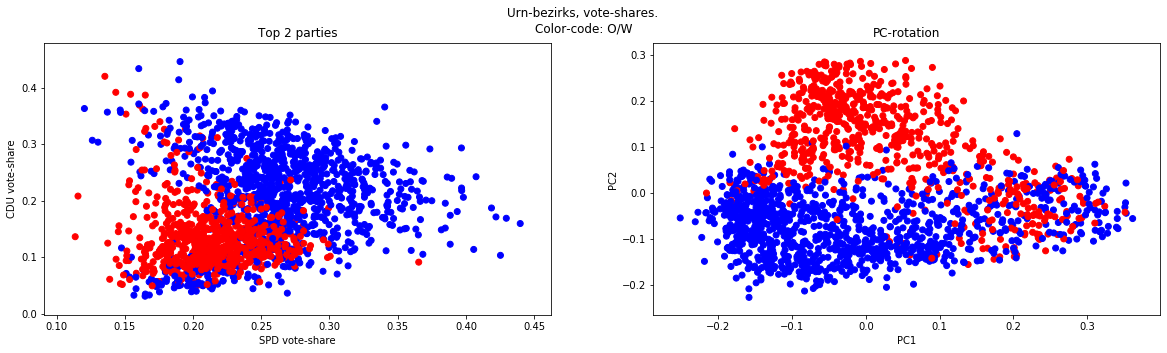

In [63]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Urn-bezirks, vote-shares. \nColor-code: O/W')

p1.scatter( VS_urn_np[:, 0], 
            VS_urn_np[:, 1],
            c= OW_ccode );
p1.set(xlabel= major_parties[0] + ' vote-share', 
       ylabel=  major_parties[1] + ' vote-share', 
       title = "Top 2 parties")

p2.scatter( VS_urn_np_PC[:, 0], 
            VS_urn_np_PC[:, 1],
            c= OW_ccode );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1'), Text(0.5, 1.0, 'PC-rotation')]

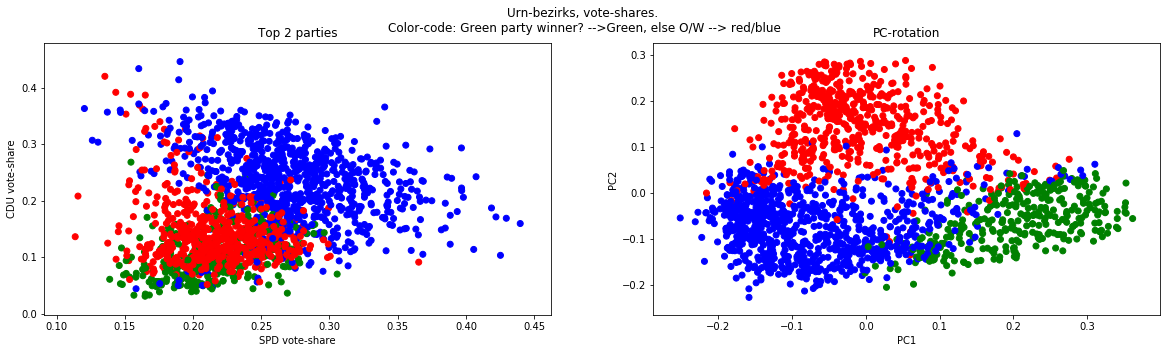

In [104]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Urn-bezirks, vote-shares. \nColor-code: Green party winner? -->Green, else O/W --> red/blue')

p1.scatter( VS_urn_np[:, 0], 
            VS_urn_np[:, 1],
            c= Gwinner_OW_ccode );
p1.set(xlabel= major_parties[0] + ' vote-share', 
       ylabel=  major_parties[1] + ' vote-share', 
       title = "Top 2 parties")

p2.scatter( VS_urn_np_PC[:, 0], 
            VS_urn_np_PC[:, 1],
            c= Gwinner_OW_ccode );
p2.set(xlabel= 'PC1', ylabel='PC2', title="PC-rotation")

In [90]:
reload(vf)

<module 'votinglib_funcs' from '/Users/lana/Documents/projects/voting_patterns/calculations/votinglib_funcs.py'>

In [91]:
clustercode_2, percW_2 = vf.cleanclusters( 2, VS_urn, OW_urn )
clustercode_3, percW_3 = vf.cleanclusters( 3, VS_urn, OW_urn )

C0 =  VS_urn_np[ clustercode_3 == 0, :]
C1 =  VS_urn_np[ clustercode_3 == 1, :]
C2 =  VS_urn_np[ clustercode_3 == 2, :]

print(C0.shape)
print(C1.shape)
print(C2.shape)
print( percW_3)

C02        = np.mean(C2, axis=0)-np.mean(C0, axis=0)
C02_normed = C02/vf.norm(C02)

C01        = np.mean(C2, axis=0)-np.mean(C1, axis=0)
C01_normed = C01/vf.norm(C01)

(782, 6)
(513, 6)
(484, 6)
[0.9450127877237852, 0.6335282651072125, 0.022727272727272728]


In [92]:
DU_rot_OW  = vf.rotate_data_along_vec_PCs( VS_urn_np, OW_vec     )
DU_rot_C01 = vf.rotate_data_along_vec_PCs( VS_urn_np, C01_normed )
DU_rot_C02 = vf.rotate_data_along_vec_PCs( VS_urn_np, C02_normed )
# Sanity check:
# m,n = np.random.randint(1,1778,2)
# print( dist(D2[m,:],  D2[n,:] ) - dist(Dat[m,:], Dat[n,:]) )

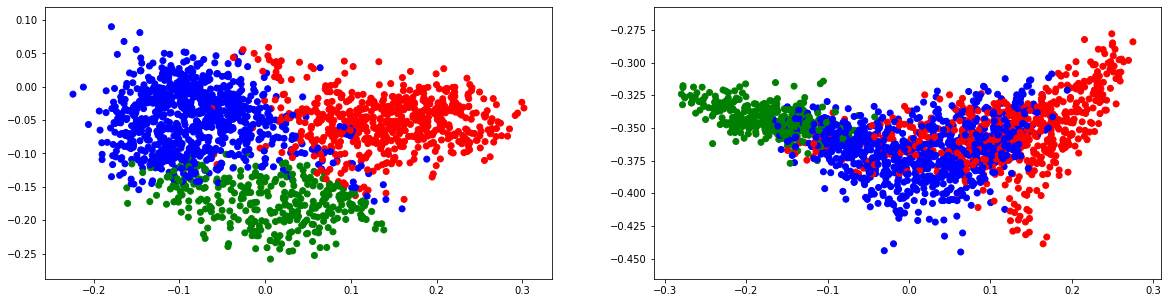

In [105]:
plt.rcParams['figure.figsize'] = [20, 5]
fig, (p1, p2) = plt.subplots(1, 2)

p1.scatter( DU_rot_OW[:,0], 
            DU_rot_OW[:,2],
            c = Gwinner_OW_ccode   )
p2.scatter( DU_rot_C01[:,0], 
            DU_rot_C01[:,1],
            c = Gwinner_OW_ccode   )